# Wigner to Density Operator Pipeline

In [1]:
import numpy as np
from scipy.linalg import expm, sqrtm
from scipy.special import factorial
from scipy.ndimage import gaussian_filter
from skimage import measure
from collections import defaultdict
import cvxpy as cp
import pickle
import matplotlib.pyplot as plt
from matplotlib.path import Path
import numpy as np

In [2]:
def annihilation_operator(N):
  a = np.zeros((N, N), dtype=complex)
  for n in range(1, N):
    a[n-1, n] = np.sqrt(n)
  return a

In [3]:
def displacement_operator(alpha, N):
    a = annihilation_operator(N)
    a_dag = a.conj().T
    D_gen = alpha * a_dag - np.conj(alpha) * a
    return expm(D_gen)

In [4]:
def parity_operator(N):
    a = annihilation_operator(N)
    a_dag = a.conj().T
    number_operator = a_dag @ a
    return expm(1j * np.pi * number_operator)

In [5]:
def parity_operator_fock(N):
    return np.diag([(-1)**n for n in range(N)])

In [6]:
def wigner(alpha, rho, N):
    D = displacement_operator(alpha, N)
    P = parity_operator(N)
    D_dag = D.conj().T
    return (2 / np.pi) * np.real(np.trace(D @ P @ D_dag @ rho))

In [7]:
def get_measure_op(alpha, N):
  D = displacement_operator(alpha, N)
  P = parity_operator(N)
  D_dag = D.conj().T
  I = np.eye(N)
  return 0.5 * (I + D @ P @ D_dag)

In [8]:
def fidelity(rho_reconstructed, rho_true):
    root_rho_true = sqrtm(rho_true)
    inner = root_rho_true @ rho_reconstructed @ root_rho_true
    sqrt_inner = sqrtm(inner)
    fid = np.real(np.trace(sqrt_inner))
    return fid ** 2

In [9]:
def trace_distance(rho1, rho2):
    delta = rho1 - rho2
    abs_delta = sqrtm(delta.conj().T @ delta)
    distance = 0.5 * np.trace(abs_delta).real
    return distance

In [10]:
def get_filtered_contours(Z, contour_level=0.2, min_length=20):
    contours = measure.find_contours(np.abs(Z), level=contour_level)
    # print('-----------')
    # print(len(contours))
    # print('----------')
    def contour_length(contour):
        d = np.diff(contour, axis=0)
        return np.sum(np.sqrt(np.sum(d**2, axis=1)))
    filtered_contours = [cnt for cnt in contours if contour_length(cnt) > min_length]
    return filtered_contours

def convert_contour_to_physical(contour, X, Y):
    physical_x = np.interp(contour[:, 1], np.arange(len(X)), X)
    physical_y = np.interp(contour[:, 0], np.arange(len(Y)), Y)
    return np.column_stack((physical_x, physical_y))

def sample_contours_and_background(X, Y, Z, contour_level=0.2, min_length=2, total_points=250, inside_ratio=0.4):
    wigner_data = Z.copy()
    height, width = wigner_data.shape
    edge_row = height - 1
    edge_col = width - 1
    b = (sum(wigner_data[edge_row, :]) +
        sum(wigner_data[:, edge_col]) +
        sum(wigner_data[0, :]) +
        sum(wigner_data[:, 0])) / (2 * (width + height - 2))
    wigner_data = wigner_data - b

    # Normalize the Wigner function
    dx = X[1] - X[0]
    dy = Y[1] - Y[0]

    wigner_integral = np.sum(wigner_data) * dx * dy
    wigner_data /= wigner_integral
    sigma = 3
    wigner_data = gaussian_filter(wigner_data, sigma=sigma)

    filtered_contours = get_filtered_contours(wigner_data, contour_level, min_length)

    # fig, ax = plt.subplots(figsize=(8, 6))
    # extent = [X.min(), X.max(), Y.min(), Y.max()]
    # im = ax.imshow(Z, extent=extent, origin='lower', aspect='auto')
    # ax.set_xlabel('X')
    # ax.set_ylabel('Y')
    # ax.set_title('Original Wigner Function with Contours')

    # for contour in filtered_contours:
    #     ix = np.clip(contour[:, 1].astype(int), 0, len(X) - 1)
    #     iy = np.clip(contour[:, 0].astype(int), 0, len(Y) - 1)
    #     ax.plot(X[ix], Y[iy], color='white')

    # fig.colorbar(im, label='Wigner Function')
    # plt.show()


    roi_polygons = [convert_contour_to_physical(contour, X, Y) for contour in filtered_contours]
    XX, YY = np.meshgrid(X, Y, indexing='ij')
    grid_points = np.column_stack((XX.ravel(), YY.ravel()))
    I, J = np.indices((len(X), len(Y)))
    grid_indices = np.column_stack((I.ravel(), J.ravel()))
    inside_mask = np.zeros(len(grid_points), dtype=bool)
    for polygon in roi_polygons:
        poly_path = Path(polygon)
        inside_mask |= poly_path.contains_points(grid_points)
    inside_points = grid_points[inside_mask]
    outside_points = grid_points[~inside_mask]
    inside_idx = grid_indices[inside_mask]
    outside_idx = grid_indices[~inside_mask]
    desired_inside = int(total_points * inside_ratio)
    desired_outside = total_points - desired_inside
    if len(inside_points) < desired_inside:
        sampled_inside_points = inside_points
        sampled_inside_idx = inside_idx
        extra_needed = total_points - len(inside_points)
        if len(outside_points) < extra_needed:
            sampled_outside_points = outside_points
            sampled_outside_idx = outside_idx
        else:
            samp_idx = np.random.choice(len(outside_points), size=extra_needed, replace=False)
            sampled_outside_points = outside_points[samp_idx]
            sampled_outside_idx = outside_idx[samp_idx]
    elif len(outside_points) < desired_outside:
        sampled_outside_points = outside_points
        sampled_outside_idx = outside_idx
        extra_needed = total_points - len(outside_points)
        if len(inside_points) < extra_needed:
            sampled_inside_points = inside_points
            sampled_inside_idx = inside_idx
        else:
            samp_idx = np.random.choice(len(inside_points), size=extra_needed, replace=False)
            sampled_inside_points = inside_points[samp_idx]
            sampled_inside_idx = inside_idx[samp_idx]
    else:
        samp_inside = np.random.choice(len(inside_points), size=desired_inside, replace=False)
        samp_outside = np.random.choice(len(outside_points), size=desired_outside, replace=False)
        sampled_inside_points = inside_points[samp_inside]
        sampled_inside_idx = inside_idx[samp_inside]
        sampled_outside_points = outside_points[samp_outside]
        sampled_outside_idx = outside_idx[samp_outside]
    sampled_points = np.concatenate([sampled_inside_points, sampled_outside_points], axis=0)
    sampled_indices = np.concatenate([sampled_inside_idx, sampled_outside_idx], axis=0)
    sampled_X = sampled_points[:, 0]
    sampled_Y = sampled_points[:, 1]
    sampled_Z = np.array([Z[i, j] for i, j in sampled_indices])
    return sampled_X, sampled_Y, sampled_Z

In [11]:
def sample_measurement_operators(X, Y, Z, N, num_samples=100):
    # sample_contours_and_background should return three 1D arrays of length num_samples:
    #   sampled_X, sampled_Y, sampled_Z
    sampled_X, sampled_Y, sampled_Z = sample_contours_and_background(X, Y, Z)

    alpha_samples = []
    w_exp_measurements = []
    measurement_operators = []

    for x, y, w_val in zip(sampled_X, sampled_Y, sampled_Z):
        α = x + 1j*y
        # convert Wigner to expectation value via your calibration
        w_k = 0.5 * (1 + (np.pi/2) * w_val)

        alpha_samples.append(α)
        w_exp_measurements.append(w_k)
        measurement_operators.append(get_measure_op(α, N))

    return alpha_samples, w_exp_measurements, measurement_operators

In [12]:
def reconstruct_density_matrix(w_exp_measurements, measurement_operators, N, solver='SCS'):
    rho = cp.Variable((N, N), complex=True)

    # Define constraints:
    #  - Hermitian: rho == rho.H
    #  - Positive semidefinite: rho >> 0 replaced by using a zero matrix
    #  - Normalized: trace(rho) == 1
    constraints = [
        rho == rho.H,                   # Hermitian constraint
        rho >> np.zeros((N, N)),         # Positive semidefinite constraint
        cp.trace(rho) == 1              # Trace equals 1
    ]

    # Build the objective function (least squares formulation)
    objective_terms = []
    for i in range(len(measurement_operators)):
        E_k_numpy = measurement_operators[i]  # measurement operator as a numpy array
        w_k = w_exp_measurements[i]             # experimental measurement value

        # The term is the squared difference of the predicted measurement value
        # (given by trace(E_k @ rho)) and the experimental outcome.
        term = cp.square(cp.abs(cp.trace(E_k_numpy @ rho) - w_k))
        objective_terms.append(term)

    # Formulate the overall optimization objective by summing the individual terms.
    objective = cp.Minimize(cp.sum(objective_terms))

    # Define and solve the optimization problem.
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=solver)

    return rho.value, prob

In [13]:
def get_density_matrix(data, N, num_samples=1000):
    X, Y, Z = data
    alpha_samples, w_exp_measurements, measurement_operators = sample_measurement_operators(X, Y, Z, N, num_samples)
    reconstructed_rho, prob = reconstruct_density_matrix(w_exp_measurements, measurement_operators, N, solver='SCS')
    return reconstructed_rho

In [14]:
def plot_wigner_comparison_with_file(file_path, reconstructed_rho):
    with open(file_path, 'rb') as f:
        X, Y, Z = pickle.load(f)

    reconstructed_Z = np.zeros_like(Z, dtype=float)

    for i in range(len(X)):
        for j in range(len(Y)):
            alpha = X[i] + 1j * Y[j]
            reconstructed_Z[i, j] = wigner(alpha, reconstructed_rho, N)

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    extent = [X.min(), X.max(), Y.min(), Y.max()]

    im0 = axs[0].imshow(Z, extent=extent, origin='lower', cmap='jet', aspect='auto')
    axs[0].set_xlabel('X')
    axs[0].set_ylabel('Y')
    axs[0].set_title('Original Wigner Function')
    fig.colorbar(im0, ax=axs[0], label='Wigner Function')

    im1 = axs[1].imshow(reconstructed_Z, extent=extent, origin='lower', cmap='jet', aspect='auto')
    axs[1].set_xlabel('X')
    axs[1].set_ylabel('Y')
    axs[1].set_title('Reconstructed Wigner Function')
    fig.colorbar(im1, ax=axs[1], label='Wigner Function')

    plt.tight_layout()
    plt.show()

In [15]:
def plot_wigner_comparison_with_data(data, reconstructed_rho):
    X, Y, Z = data

    reconstructed_Z = np.zeros_like(Z, dtype=float)

    for i in range(len(X)):
        for j in range(len(Y)):
            alpha = X[i] + 1j * Y[j]
            reconstructed_Z[i, j] = wigner(alpha, reconstructed_rho, N)

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    extent = [X.min(), X.max(), Y.min(), Y.max()]

    im0 = axs[0].imshow(Z, extent=extent, origin='lower', cmap='jet', aspect='auto')
    axs[0].set_xlabel('X')
    axs[0].set_ylabel('Y')
    axs[0].set_title('Original Wigner Function')
    fig.colorbar(im0, ax=axs[0], label='Wigner Function')

    im1 = axs[1].imshow(reconstructed_Z, extent=extent, origin='lower', cmap='jet', aspect='auto')
    axs[1].set_xlabel('X')
    axs[1].set_ylabel('Y')
    axs[1].set_title('Reconstructed Wigner Function')
    fig.colorbar(im1, ax=axs[1], label='Wigner Function')

    plt.tight_layout()
    plt.show()
    print(Z - reconstructed_Z)

In [16]:
def generate_wigner_grid(rho, N, xlim=(-3, 3), ylim=(-3, 3), nx=100, ny=50):
    X = np.linspace(xlim[0], xlim[1], nx)
    Y = np.linspace(ylim[0], ylim[1], ny)

    Z = np.empty((nx, ny), dtype=float)

    for i in range(nx):
        for j in range(ny):
            alpha = X[i] + 1j * Y[j]
            Z[i, j] = wigner(alpha, rho, N)

    return X, Y, Z

In [17]:
def fock_density_matrix(n, N):
    rho = np.zeros((N, N), dtype=complex)
    if 0 <= n < N:
        rho[n, n] = 1.0
    return rho

def coherent_state_vector(alpha, N):
    n = np.arange(N)
    coeffs = np.exp(-0.5 * np.abs(alpha)**2) * alpha**n / np.sqrt(factorial(n))
    return coeffs


def coherent_density_matrix(alpha, N):
    psi = coherent_state_vector(alpha, N)
    return np.outer(psi, np.conj(psi))


def cat_density_matrix(alpha, N, parity='even'):
    psi_p = coherent_state_vector(alpha, N) + coherent_state_vector(-alpha, N)
    psi_m = coherent_state_vector(alpha, N) - coherent_state_vector(-alpha, N)
    psi = psi_p if parity=='even' else psi_m

    psi = psi / np.linalg.norm(psi)
    return np.outer(psi, np.conj(psi))

In [18]:
N = 10 # number of fock bases to decompose into
alpha = 2.0 + 0.0j
# Fock state |n=1>
rho_fock = fock_density_matrix(1, N)

# Coherent state |alpha>
rho_coh = coherent_density_matrix(alpha, N)

# Even cat state (|alpha> + |−alpha>)
rho_cat_even = cat_density_matrix(alpha, N, parity='even')

# Now you can plug any of these into your wigner() routine:
X_fock, Y_fock, Z_fock = generate_wigner_grid(rho_fock, N)
X_coh, Y_coh, Z_coh = generate_wigner_grid(rho_coh, N)
X_cat, Y_cat, Z_cat = generate_wigner_grid(rho_cat_even, N)

# For Fock States

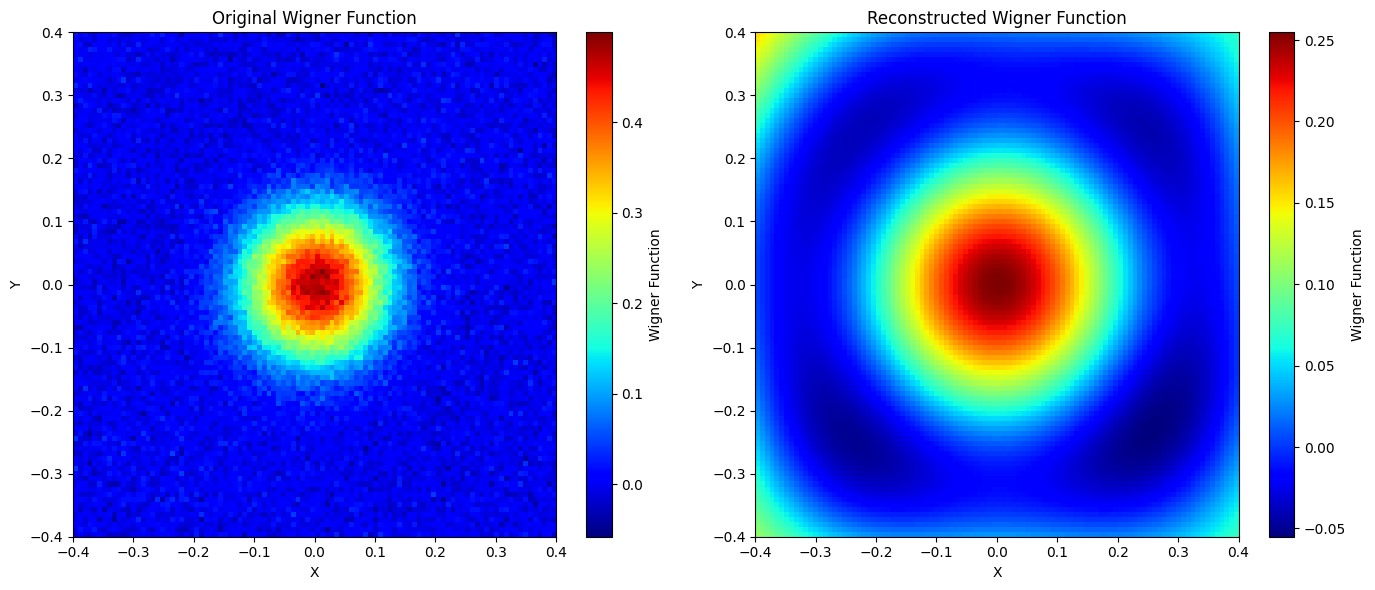

In [19]:
file_path = "../data/experimental/wigner_fock_zero.pickle" # include the file with the Wigner function you want

# load the data
with open(file_path, 'rb') as f:
    data = pickle.load(f)

# reconstruct the density operator from fixed number of samples
num_samples = 1000
reconstructed_rho = get_density_matrix(data, N, num_samples)

# compare the original wigner state with the rebuilt one from
plot_wigner_comparison_with_file(file_path, reconstructed_rho)

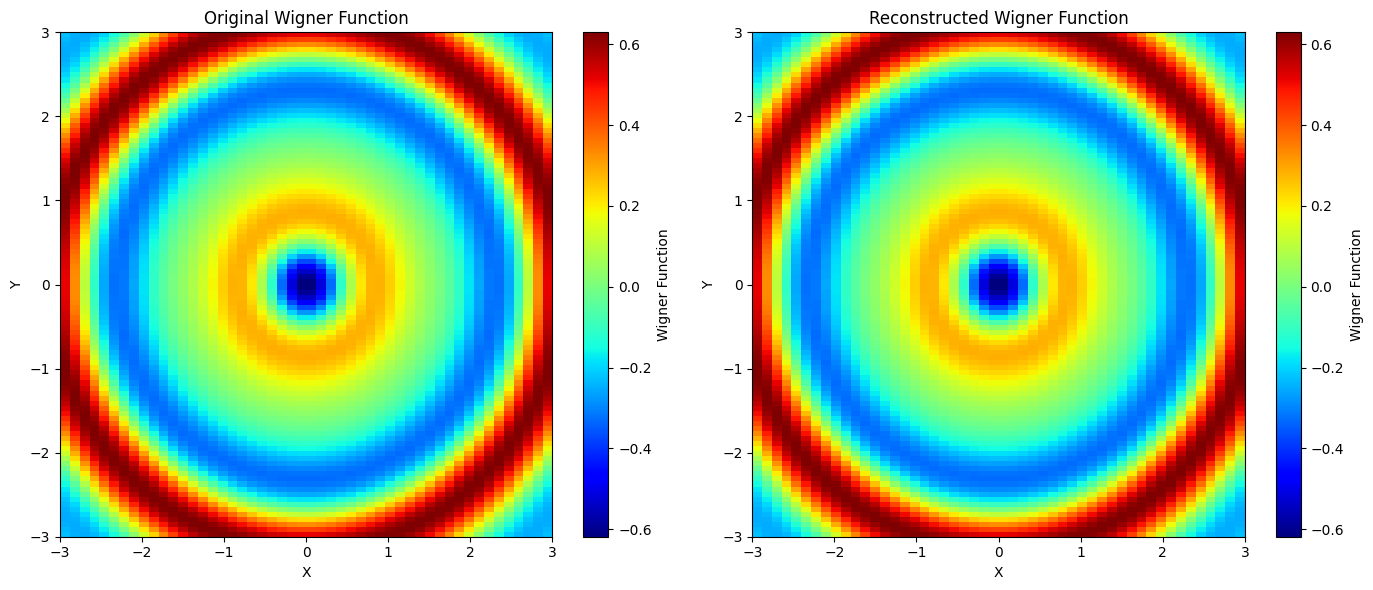

[[-2.50351415e-06 -6.51137608e-06 -1.23944299e-05 ... -2.48169820e-05
  -2.15117121e-05 -1.97769818e-05]
 [-5.88520160e-06 -1.11111121e-05 -1.71190072e-05 ... -2.67434273e-05
  -2.33638722e-05 -2.05097597e-05]
 [-9.99696934e-06 -1.59539878e-05 -2.10939978e-05 ... -2.79758581e-05
  -2.54448170e-05 -2.18614271e-05]
 ...
 [-2.18460404e-05 -2.35934490e-05 -2.51806637e-05 ... -1.33971417e-05
  -9.92789398e-06 -8.75595899e-06]
 [-2.15533223e-05 -2.24697014e-05 -2.47131221e-05 ... -1.17281133e-05
  -8.33051465e-06 -8.76862882e-06]
 [-2.18873952e-05 -2.16209251e-05 -2.36513063e-05 ... -9.82726203e-06
  -7.39815297e-06 -9.72153193e-06]]


In [20]:
data = (X_fock, Y_fock, Z_fock)
# reconstruct the density operator from fixed number of samples
num_samples = 1000
reconstructed_rho = get_density_matrix(data, N, num_samples)
plot_wigner_comparison_with_data(data, reconstructed_rho)

In [21]:
fidelity(reconstructed_rho, rho_fock)

np.float64(0.9998926440321569)

In [22]:
trace_distance(reconstructed_rho, rho_fock)

np.float64(0.00011543452922538237)

# For Cat States

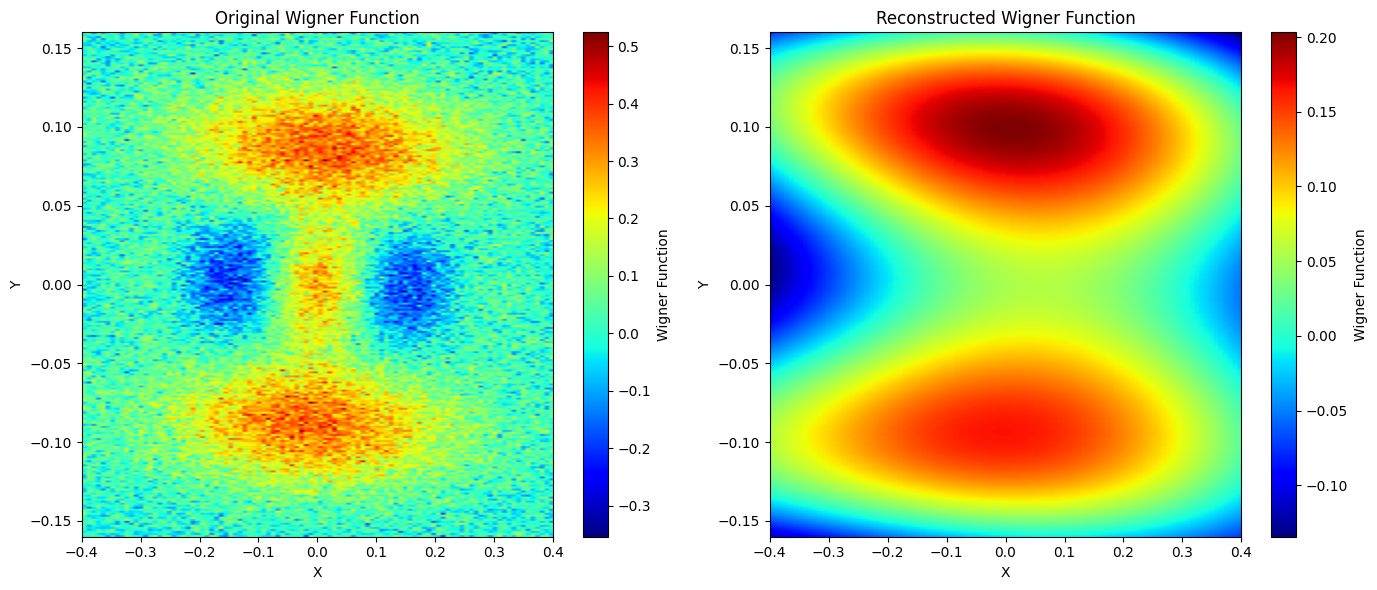

In [23]:
file_path = "../data/experimental/wigner_cat_plus.pickle" # include the file with the Wigner function you want

# load the data
with open(file_path, 'rb') as f:
    data = pickle.load(f)

# reconstruct the density operator from fixed number of samples
num_samples = 1000
reconstructed_rho = get_density_matrix(data, N, num_samples)

# compare the original wigner state with the rebuilt one from
plot_wigner_comparison_with_file(file_path, reconstructed_rho)

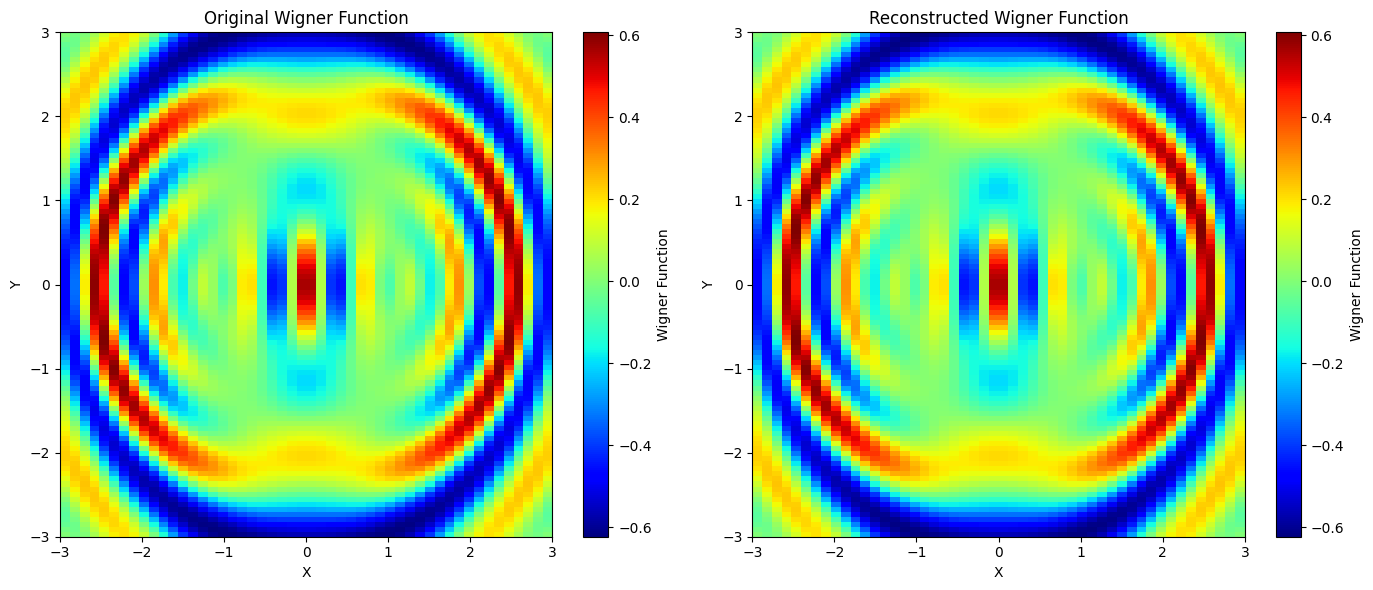

[[ 6.21954076e-09 -1.75673443e-08 -2.01168024e-08 ...  3.30792141e-08
   3.99002256e-08  6.47171875e-08]
 [-2.73373625e-09 -1.73274723e-08 -3.83652200e-09 ...  4.19588821e-08
   2.82219820e-08  4.61388412e-08]
 [-7.51620530e-09 -8.90699831e-09  1.91704045e-08 ...  6.04297245e-08
   2.56169035e-08  2.86012547e-08]
 ...
 [-1.12771530e-07 -4.97846480e-08 -2.45257713e-09 ... -2.72676980e-08
  -6.06813127e-08 -1.03087892e-07]
 [-1.43275804e-07 -8.48980830e-08 -2.12547955e-08 ... -3.81146589e-08
  -8.19391211e-08 -1.19327771e-07]
 [-1.64283250e-07 -1.22340173e-07 -5.22296268e-08 ... -5.79393380e-08
  -1.04782224e-07 -1.29470891e-07]]


In [24]:
data = (X_cat, Y_cat, Z_cat)
# reconstruct the density operator from fixed number of samples
num_samples = 1000
reconstructed_rho = get_density_matrix(data, N, num_samples)
plot_wigner_comparison_with_data(data, reconstructed_rho)

In [25]:
fidelity(reconstructed_rho, rho_cat_even)

np.float64(0.9999998797026483)

In [26]:
trace_distance(reconstructed_rho, rho_cat_even)

np.float64(6.460959512199253e-07)

# For Coherent States

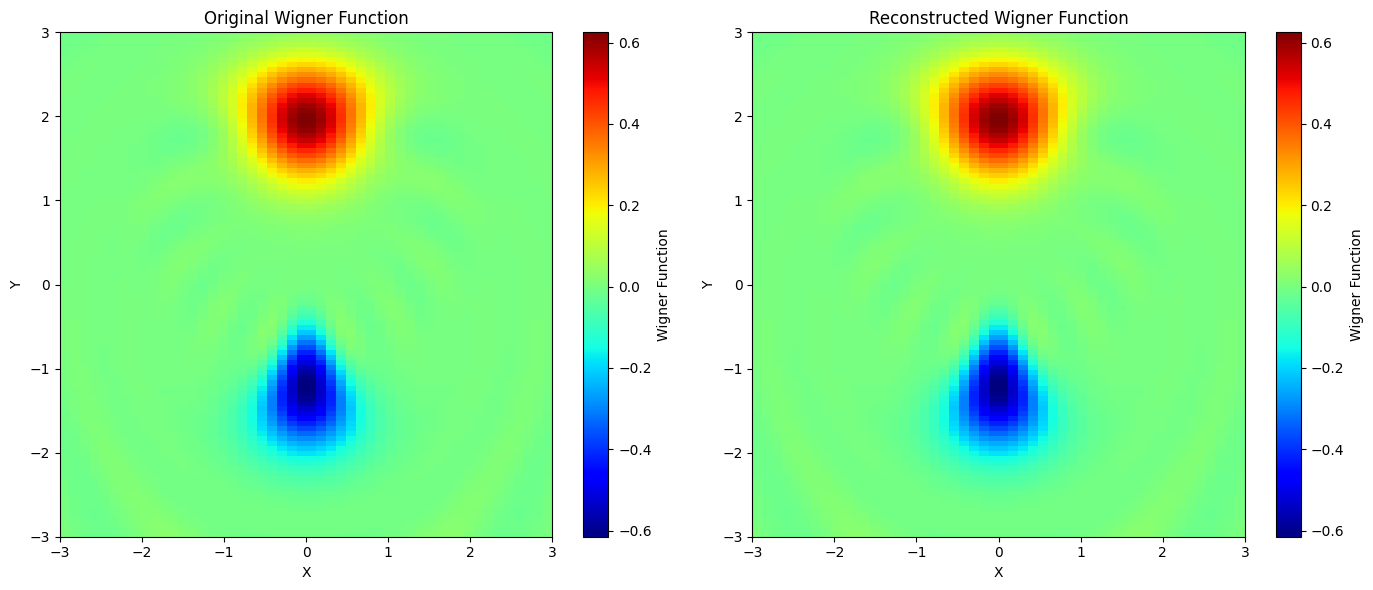

[[ 2.76709690e-06  2.95107612e-06  1.95193493e-06 ...  1.91441718e-06
   1.29588176e-06  4.63689495e-07]
 [ 3.37242412e-06  3.11070041e-06  1.63069533e-06 ...  1.94429092e-06
   1.43626696e-06  5.70509289e-07]
 [ 3.79410502e-06  3.01947136e-06  1.11634613e-06 ...  1.89314362e-06
   1.54320574e-06  6.85863195e-07]
 ...
 [-7.33593770e-07 -8.39380522e-07 -6.45212627e-07 ... -1.52381633e-06
  -1.90523866e-06 -1.38736234e-06]
 [-8.09406314e-07 -1.08660456e-06 -9.78470019e-07 ... -1.60745603e-06
  -1.58903652e-06 -8.29544225e-07]
 [-7.36549353e-07 -1.23134345e-06 -1.30240118e-06 ... -1.48270127e-06
  -1.12942947e-06 -2.52318230e-07]]


In [27]:
data = (X_coh, Y_coh, Z_coh)
# reconstruct the density operator from fixed number of samples
num_samples = 1000
reconstructed_rho = get_density_matrix(data, N, num_samples)
plot_wigner_comparison_with_data(data, reconstructed_rho)

In [28]:
fidelity(reconstructed_rho, rho_cat_even)

np.float64(0.49452865296557513)

In [29]:
trace_distance(reconstructed_rho, rho_cat_even)

np.float64(0.7093021236523599)

# Task C

In [30]:
def make_noisy_data(data, std_dev):
    X, Y, Z = data

    Z_noisy = Z.copy()
    for i in range(len(Z_noisy)):
        for j in range(len(Z_noisy[0])):
            Z_noisy[i][j] += np.random.normal(0, std_dev)

    noisy_data = (X, Y, Z_noisy)

    return noisy_data

In [31]:
def plot_fidelity_stdev(data, low_stdev, high_stdev, num_points, N):
    stdevs = np.linspace(low_stdev, high_stdev, num_points)
    fidelities = []

    noise_free_rho = get_density_matrix(data, N)

    for stdev in stdevs:
        noisy_data = make_noisy_data(data, stdev)
        noisy_rho = get_density_matrix(noisy_data, N)
        f = fidelity(noise_free_rho, noisy_rho)
        fidelities.append(f)

    # Plot fidelity as a function of noise standard deviation
    plt.figure(figsize=(8, 5))
    plt.plot(stdevs, fidelities, marker='o', label='Fidelity')
    plt.xlabel('Standard Deviation')
    plt.ylabel('Fidelity')
    plt.title('Fidelity vs. Noise Standard Deviation')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [32]:
def plot_tracedist_stdev(data, low_stdev, high_stdev, num_points, N):
    stdevs = np.linspace(low_stdev, high_stdev, num_points)
    tracedists = []

    noise_free_rho = get_density_matrix(data, N)

    for stdev in stdevs:
        noisy_data = make_noisy_data(data, stdev)
        noisy_rho = get_density_matrix(noisy_data, N)
        f = fidelity(noise_free_rho, noisy_rho)
        tracedists.append(f)

    # Plot fidelity as a function of noise standard deviation
    plt.figure(figsize=(8, 5))
    plt.plot(stdevs, tracedists, marker='o', label='Trace Distance')
    plt.xlabel('Standard Deviation')
    plt.ylabel('Trace Distance')
    plt.title('Trace Distance vs. Noise Standard Deviation')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Real Fock Fidelity/Trace

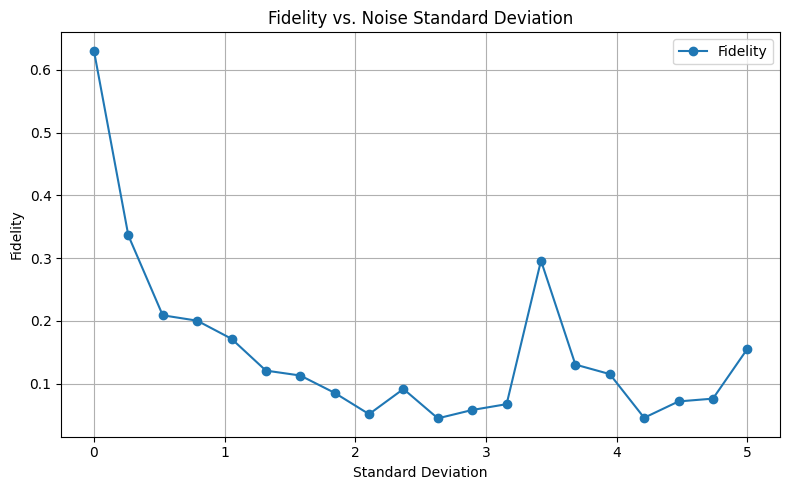

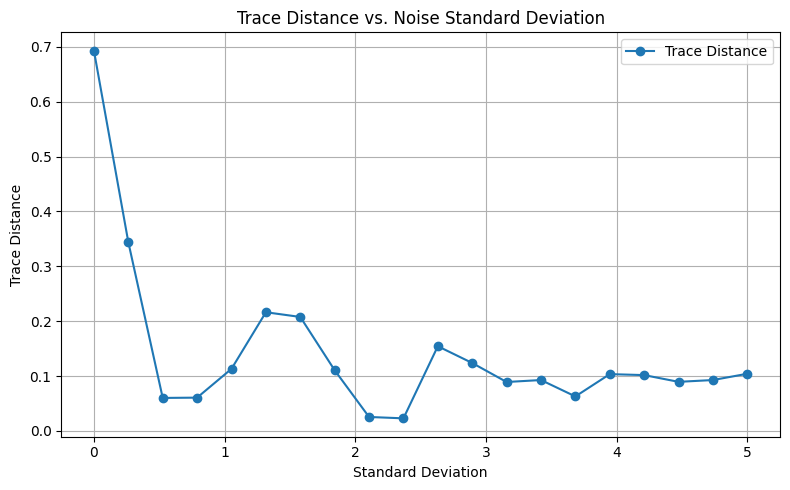

In [33]:
fock_file = "../data/experimental/wigner_fock_one.pickle"
with open(fock_file, 'rb') as f:
    data = pickle.load(f)
plot_fidelity_stdev(data, 0, 5, 20, N)
plot_tracedist_stdev(data, 0, 5, 20, N)

# Real Cat Fidelity/Trace

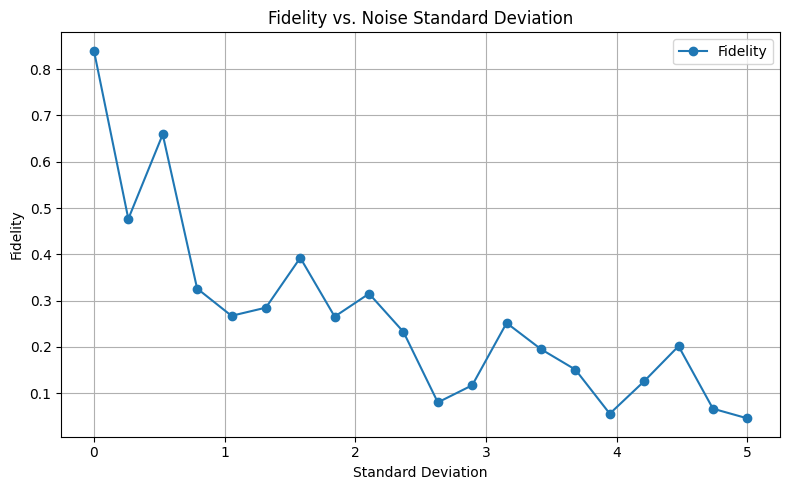

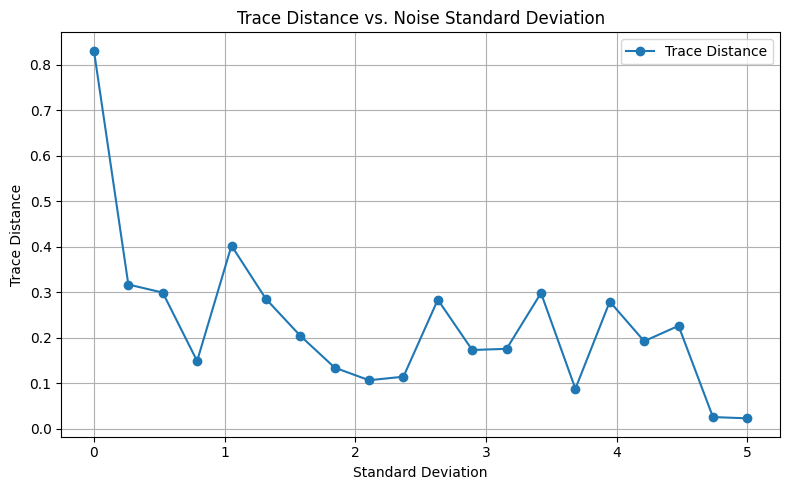

In [34]:
cat_file = "../data/experimental/wigner_cat_plus.pickle"
with open(cat_file, 'rb') as f:
    data = pickle.load(f)
plot_fidelity_stdev(data, 0, 5, 20, N)
plot_tracedist_stdev(data, 0, 5, 20, N)

# Simulated Coh Fidelity/Trace

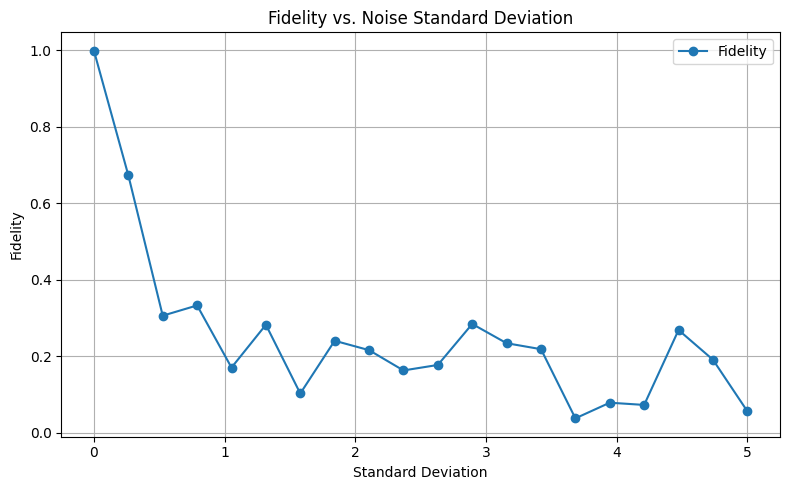

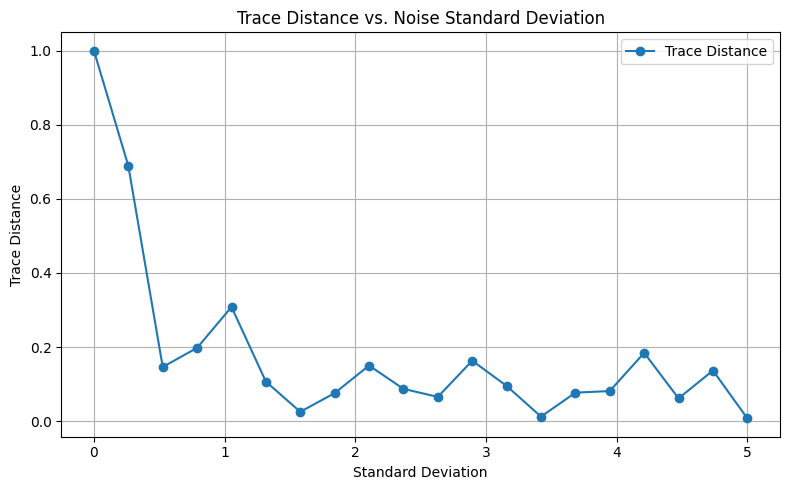

In [35]:
coh_data = (X_coh, Y_coh, Z_coh)
plot_fidelity_stdev(coh_data, 0, 5, 20, N)
plot_tracedist_stdev(coh_data, 0, 5, 20, N)